In [1]:
# 首先导入包
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
# This is for the progress bar.
from tqdm import tqdm
import seaborn as sns
# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
import math
from torch.nn import functional as F
from sklearn.preprocessing import MinMaxScaler

In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_test_split(data_set, test_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(test_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [3]:
data = pd.read_csv("TripData_cleaned.csv")
data = data.drop('Unnamed: 0', axis=1)
data.head()

,lpep_pickup_datetime,Lpep_dropoff_datetime,Passenger_count,Trip_distance,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Total_amount,Trip_duration,Pickup_time,Speed,Pickup_cluster,Dropoff_cluster,year,month,day,time_span
0,2015-04-01 00:00:00,2015/4/1 0:08,1,3.08,-73.958817,40.716824,-73.982971,40.696007,14.76,8.0,1.427818e+09,23.100000,7,25,2015,4,1,0
1,2015-04-01 00:00:00,2015/4/1 0:07,1,1.21,-73.937531,40.804501,-73.946800,40.815998,8.30,7.0,1.427818e+09,10.371429,11,11,2015,4,1,0
2,2015-04-01 00:00:00,2015/4/1 0:02,1,0.64,-73.955818,40.681152,-73.955406,40.687145,6.00,2.0,1.427818e+09,19.200000,0,18,2015,4,1,0
3,2015-04-01 00:00:00,2015/4/1 0:05,1,1.34,-73.830551,40.759460,-73.825363,40.741589,7.80,5.0,1.427818e+09,16.080000,20,20,2015,4,1,0
4,2015-04-01 00:00:00,2015/4/1 0:05,1,0.98,-73.912086,40.775356,-73.915474,40.764091,7.30,5.0,1.427818e+09,11.760000,17,19,2015,4,1,0


In [4]:
# 根据指定的列进行分组，并对Passenger_count进行求和
grouped_data = data.groupby(['year', 'month', 'day', 'time_span', 'Pickup_cluster']).agg(
    {'Passenger_count': 'sum'}).reset_index()
# 将列名 'time_span' 修改为 'hour'
grouped_data = grouped_data.rename(columns={'time_span': 'hour'})

# 初始化 MinMaxScaler
scaler = MinMaxScaler()

# 因此我们使用 .values.reshape(-1, 1) 转换 Pickup_cluster 列
grouped_data['Passenger_count'] = scaler.fit_transform(grouped_data[['Passenger_count']])

grouped_data.head()

,year,month,day,hour,Pickup_cluster,Passenger_count
0,2015,4,1,0,0,0.042034
1,2015,4,1,0,1,0.058983
2,2015,4,1,0,2,0.157966
3,2015,4,1,0,3,0.014237
4,2015,4,1,0,4,0.031186


In [5]:
passenger_count = []
cluster_count = len(grouped_data['Pickup_cluster'].unique())
temp_count = [0]*cluster_count
last_index = -1

for i in range(len(grouped_data)):
    # 使用 int() 函数确保索引是整数
    current_index = int(grouped_data.iloc[i]['Pickup_cluster'])
    
    if current_index < last_index:
        passenger_count.append(temp_count)
        temp_count = [0] * cluster_count

    temp_count[current_index] = grouped_data.iloc[i]['Passenger_count']
    last_index = current_index

# 添加最后一个周期的数据
passenger_count.append(temp_count)
    
len(passenger_count[0])

30

In [6]:
passenger_count = np.array(passenger_count)
passenger_count

array([[0.0420339 , 0.05898305, 0.1579661 , ..., 0.00474576, 0.00610169,
        0.00542373],
       [0.0379661 , 0.02576271, 0.11661017, ..., 0.00067797, 0.00542373,
        0.00067797],
       [0.02372881, 0.01220339, 0.0820339 , ..., 0.00067797, 0.00135593,
        0.00067797],
       ...,
       [0.08474576, 0.26847458, 0.14169492, ..., 0.00745763, 0.01966102,
        0.01288136],
       [0.12745763, 0.23322034, 0.12271186, ..., 0.00949153, 0.01762712,
        0.01016949],
       [0.06711864, 0.13762712, 0.0820339 , ..., 0.00338983, 0.00949153,
        0.00677966]])

In [7]:
class TripData(Dataset):
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

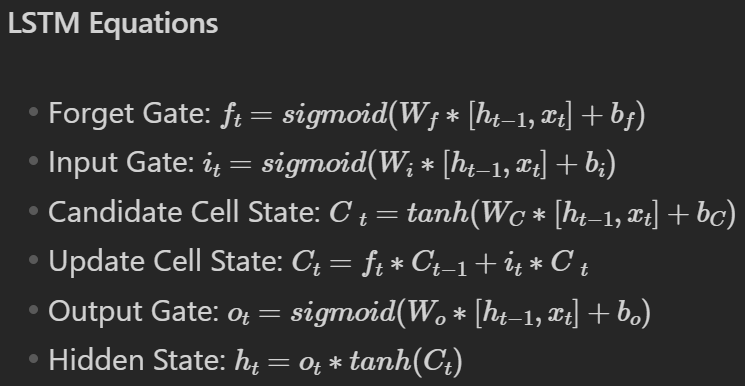
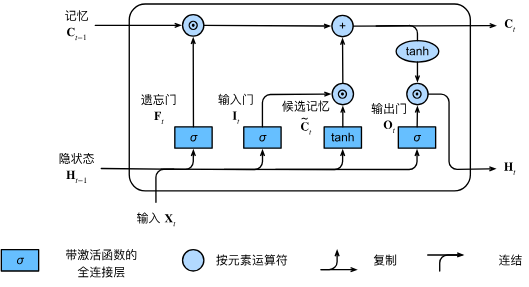

In [8]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(device) # 初始化隐藏状态h0
        c0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(device)  # 初始化记忆状态c0
        #print(f"x.shape:{x.shape},h0.shape:{h0.shape},c0.shape:{c0.shape}")
        out, _ = self.lstm(x, (h0, c0))  # LSTM前向传播
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出作为预测结果
        return out

In [9]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = [0,1,2,3,4] # TODO: Select suitable feature columns.
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

In [10]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss() # Define your loss function, do not modify this.

    # Define your optimization algorithm. 
    optimizer=torch.optim.Adam(model.parameters(),lr=0.0001,betas=(0.5,0.999))

    writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Test loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/Test', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 20010106,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'test_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 500,     # Number of epochs.            
    'batch_size': 16, 
    'learning_rate': 1e-4,              
    'early_stop': 400,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/LSTM.ckpt'  # Your model will be saved here.
}

In [12]:
print(f"len(Passenger_count):{len(passenger_count)}")

len(Passenger_count):449


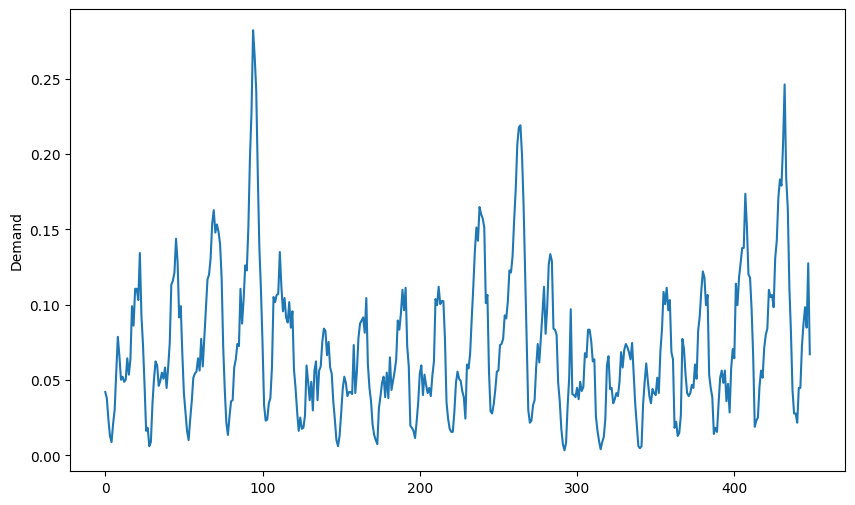

In [13]:
# 从每个周期中提取第一个簇的乘客计数
first_cluster_passenger_count = [cycle[0] for cycle in passenger_count]

# 设置图表大小
plt.figure(figsize=(10, 6))

# 绘制图表
plt.plot([i for i in range(len(first_cluster_passenger_count))], first_cluster_passenger_count)

# 设置y轴标签和字体大小
plt.ylabel("Demand", fontsize=10)

# 显示图表
plt.show()

In [14]:
def split_data(data,time_step=24):
    dataX=[]
    datay=[]
    dataNew = []
    for i in range(len(data)-time_step):
        dataX.append(data[i:i+time_step])
        datay.append(data[i+time_step])
        dataNew.append(data[i:i+time_step+1])
    dataX=np.array(dataX).reshape(len(dataX),time_step,-1)
    datay=np.array(datay)
    dataNew=np.array(dataNew).reshape(len(dataNew),time_step+1,-1)
    return dataX,datay,dataNew

In [15]:
dataX,datay, dataNew=split_data(passenger_count)
print(f"dataX.shape:{dataX.shape},datay.shape:{datay.shape},dataNew.shape:{dataNew.shape}")

dataX.shape:(425, 24, 30),datay.shape:(425, 30),dataNew.shape:(425, 25, 30)


In [16]:
# 计算验证集的大小（后10%的数据）
valid_size = int(len(dataNew) * 0.1)

# 从数据集的末尾取后10%作为验证集
valid_data = dataNew[-valid_size:]

In [17]:
train_data, test_data = train_test_split(dataNew, config['test_ratio'], config['seed'])

In [18]:
# Select features
x_train, x_test, y_train, y_test = train_data[:,:-1], test_data[:,:-1], train_data[:,-1], test_data[:,-1],

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

number of features: 24


In [19]:
len(train_data)

340

In [20]:
train_dataset, valid_dataset = TripData(x_train, y=y_train), TripData(x_test, y=y_test),

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)

In [21]:
# 定义输入、隐藏状态和输出维度
input_size = cluster_count  # 输入特征维度
hidden_size = 64  # LSTM隐藏状态维度
num_layers = 5  # LSTM层数
output_size = cluster_count  # 输出维度（预测目标维度）

In [22]:
model = LSTM_model(input_size, hidden_size, num_layers, output_size).to(device) # put your model and data on the same computation device.
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 42.14it/s, loss=0.00739]


Epoch [1/500]: Train loss: 0.0102, Test loss: 0.0102
Saving model with loss 0.010...


Epoch [2/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.27it/s, loss=0.00303]


Epoch [2/500]: Train loss: 0.0078, Test loss: 0.0073
Saving model with loss 0.007...


Epoch [3/500]: 100%|██████████████████████████████████████████████████████| 22/22 [00:00<00:00, 144.74it/s, loss=0.002]


Epoch [3/500]: Train loss: 0.0051, Test loss: 0.0043
Saving model with loss 0.004...


Epoch [4/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.15it/s, loss=0.00392]


Epoch [4/500]: Train loss: 0.0041, Test loss: 0.0041
Saving model with loss 0.004...


Epoch [5/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 156.50it/s, loss=0.00267]


Epoch [5/500]: Train loss: 0.0040, Test loss: 0.0040
Saving model with loss 0.004...


Epoch [6/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.25it/s, loss=0.00259]


Epoch [6/500]: Train loss: 0.0039, Test loss: 0.0046


Epoch [7/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 144.91it/s, loss=0.00295]


Epoch [7/500]: Train loss: 0.0039, Test loss: 0.0041


Epoch [8/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 151.54it/s, loss=0.00296]


Epoch [8/500]: Train loss: 0.0039, Test loss: 0.0042


Epoch [9/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 149.83it/s, loss=0.00235]


Epoch [9/500]: Train loss: 0.0039, Test loss: 0.0042


Epoch [10/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 144.77it/s, loss=0.00241]


Epoch [10/500]: Train loss: 0.0040, Test loss: 0.0041


Epoch [11/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.71it/s, loss=0.00543]


Epoch [11/500]: Train loss: 0.0040, Test loss: 0.0043


Epoch [12/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.07it/s, loss=0.00399]


Epoch [12/500]: Train loss: 0.0040, Test loss: 0.0039
Saving model with loss 0.004...


Epoch [13/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.20it/s, loss=0.00353]


Epoch [13/500]: Train loss: 0.0040, Test loss: 0.0044


Epoch [14/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.77it/s, loss=0.00177]


Epoch [14/500]: Train loss: 0.0039, Test loss: 0.0041


Epoch [15/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.10it/s, loss=0.00571]


Epoch [15/500]: Train loss: 0.0040, Test loss: 0.0044


Epoch [16/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 138.97it/s, loss=0.00178]


Epoch [16/500]: Train loss: 0.0039, Test loss: 0.0044


Epoch [17/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 135.40it/s, loss=0.00299]


Epoch [17/500]: Train loss: 0.0039, Test loss: 0.0038
Saving model with loss 0.004...


Epoch [18/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.93it/s, loss=0.00585]


Epoch [18/500]: Train loss: 0.0040, Test loss: 0.0044


Epoch [19/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 134.83it/s, loss=0.0017]


Epoch [19/500]: Train loss: 0.0039, Test loss: 0.0044


Epoch [20/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.51it/s, loss=0.003]

Epoch [20/500]: Train loss: 0.0039, Test loss: 0.0039



Epoch [21/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.32it/s, loss=0.00145]


Epoch [21/500]: Train loss: 0.0038, Test loss: 0.0042


Epoch [22/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 128.04it/s, loss=0.00192]

Epoch [22/500]: Train loss: 0.0036, Test loss: 0.0040



Epoch [23/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 136.04it/s, loss=0.00241]


Epoch [23/500]: Train loss: 0.0033, Test loss: 0.0032
Saving model with loss 0.003...


Epoch [24/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 142.04it/s, loss=0.00668]


Epoch [24/500]: Train loss: 0.0029, Test loss: 0.0027
Saving model with loss 0.003...


Epoch [25/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 137.78it/s, loss=0.00163]

Epoch [25/500]: Train loss: 0.0024, Test loss: 0.0023


Saving model with loss 0.002...


Epoch [26/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 128.78it/s, loss=0.00154]

Epoch [26/500]: Train loss: 0.0022, Test loss: 0.0022


Saving model with loss 0.002...


Epoch [27/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.24it/s, loss=0.00111]

Epoch [27/500]: Train loss: 0.0020, Test loss: 0.0020


Saving model with loss 0.002...


Epoch [28/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.83it/s, loss=0.000826]


Epoch [28/500]: Train loss: 0.0019, Test loss: 0.0018
Saving model with loss 0.002...


Epoch [29/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.49it/s, loss=0.000771]

Epoch [29/500]: Train loss: 0.0018, Test loss: 0.0019

Epoch [30/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 130.17it/s, loss=0.000746]

Epoch [30/500]: Train loss: 0.0017, Test loss: 0.0016


Saving model with loss 0.002...


Epoch [31/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.19it/s, loss=0.00126]


Epoch [31/500]: Train loss: 0.0016, Test loss: 0.0017


Epoch [32/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.63it/s, loss=0.00213]


Epoch [32/500]: Train loss: 0.0016, Test loss: 0.0015
Saving model with loss 0.002...


Epoch [33/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 114.71it/s, loss=0.00218]


Epoch [33/500]: Train loss: 0.0016, Test loss: 0.0017


Epoch [34/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.87it/s, loss=0.000717]


Epoch [34/500]: Train loss: 0.0014, Test loss: 0.0014
Saving model with loss 0.001...


Epoch [35/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.64it/s, loss=0.00265]


Epoch [35/500]: Train loss: 0.0014, Test loss: 0.0016


Epoch [36/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 128.93it/s, loss=0.00101]


Epoch [36/500]: Train loss: 0.0014, Test loss: 0.0017


Epoch [37/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 134.95it/s, loss=0.00197]


Epoch [37/500]: Train loss: 0.0013, Test loss: 0.0017


Epoch [38/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.44it/s, loss=0.000949]


Epoch [38/500]: Train loss: 0.0013, Test loss: 0.0015


Epoch [39/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.60it/s, loss=0.00185]


Epoch [39/500]: Train loss: 0.0012, Test loss: 0.0013
Saving model with loss 0.001...


Epoch [40/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 124.78it/s, loss=0.000692]


Epoch [40/500]: Train loss: 0.0012, Test loss: 0.0012
Saving model with loss 0.001...


Epoch [41/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.43it/s, loss=0.000605]


Epoch [41/500]: Train loss: 0.0011, Test loss: 0.0012


Epoch [42/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 124.82it/s, loss=0.000671]


Epoch [42/500]: Train loss: 0.0011, Test loss: 0.0012
Saving model with loss 0.001...


Epoch [43/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.40it/s, loss=0.000514]


Epoch [43/500]: Train loss: 0.0010, Test loss: 0.0012


Epoch [44/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.42it/s, loss=0.00094]


Epoch [44/500]: Train loss: 0.0010, Test loss: 0.0011
Saving model with loss 0.001...


Epoch [45/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 128.49it/s, loss=0.000565]


Epoch [45/500]: Train loss: 0.0010, Test loss: 0.0012


Epoch [46/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.57it/s, loss=0.000551]


Epoch [46/500]: Train loss: 0.0011, Test loss: 0.0011


Epoch [47/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.60it/s, loss=0.000987]


Epoch [47/500]: Train loss: 0.0009, Test loss: 0.0010
Saving model with loss 0.001...


Epoch [48/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.73it/s, loss=0.000458]


Epoch [48/500]: Train loss: 0.0009, Test loss: 0.0009
Saving model with loss 0.001...


Epoch [49/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.32it/s, loss=0.000711]


Epoch [49/500]: Train loss: 0.0009, Test loss: 0.0009


Epoch [50/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.22it/s, loss=0.000846]


Epoch [50/500]: Train loss: 0.0009, Test loss: 0.0008
Saving model with loss 0.001...


Epoch [51/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.74it/s, loss=0.000793]


Epoch [51/500]: Train loss: 0.0008, Test loss: 0.0009


Epoch [52/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 128.32it/s, loss=0.00109]


Epoch [52/500]: Train loss: 0.0008, Test loss: 0.0008
Saving model with loss 0.001...


Epoch [53/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.20it/s, loss=0.00112]

Epoch [53/500]: Train loss: 0.0008, Test loss: 0.0009



Epoch [54/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.32it/s, loss=0.00104]

Epoch [54/500]: Train loss: 0.0008, Test loss: 0.0009



Epoch [55/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 139.02it/s, loss=0.000959]


Epoch [55/500]: Train loss: 0.0008, Test loss: 0.0009


Epoch [56/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 128.36it/s, loss=0.00156]


Epoch [56/500]: Train loss: 0.0008, Test loss: 0.0009


Epoch [57/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.90it/s, loss=0.000449]


Epoch [57/500]: Train loss: 0.0008, Test loss: 0.0008
Saving model with loss 0.001...


Epoch [58/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 135.61it/s, loss=0.000978]

Epoch [58/500]: Train loss: 0.0008, Test loss: 0.0010



Epoch [59/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.85it/s, loss=0.000766]


Epoch [59/500]: Train loss: 0.0008, Test loss: 0.0008
Saving model with loss 0.001...


Epoch [60/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 134.37it/s, loss=0.00141]


Epoch [60/500]: Train loss: 0.0008, Test loss: 0.0007
Saving model with loss 0.001...


Epoch [61/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 134.74it/s, loss=0.00122]


Epoch [61/500]: Train loss: 0.0007, Test loss: 0.0007


Epoch [62/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 99.42it/s, loss=0.000707]


Epoch [62/500]: Train loss: 0.0007, Test loss: 0.0008


Epoch [63/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.53it/s, loss=0.000914]


Epoch [63/500]: Train loss: 0.0007, Test loss: 0.0008


Epoch [64/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 122.57it/s, loss=0.000663]


Epoch [64/500]: Train loss: 0.0007, Test loss: 0.0007
Saving model with loss 0.001...


Epoch [65/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.06it/s, loss=0.000411]


Epoch [65/500]: Train loss: 0.0007, Test loss: 0.0011


Epoch [66/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.80it/s, loss=0.000786]


Epoch [66/500]: Train loss: 0.0007, Test loss: 0.0007
Saving model with loss 0.001...


Epoch [67/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 136.09it/s, loss=0.000753]


Epoch [67/500]: Train loss: 0.0007, Test loss: 0.0008


Epoch [68/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 141.96it/s, loss=0.000315]


Epoch [68/500]: Train loss: 0.0007, Test loss: 0.0007
Saving model with loss 0.001...


Epoch [69/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.84it/s, loss=0.000527]


Epoch [69/500]: Train loss: 0.0007, Test loss: 0.0007


Epoch [70/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 128.49it/s, loss=0.000625]


Epoch [70/500]: Train loss: 0.0007, Test loss: 0.0007


Epoch [71/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 138.68it/s, loss=0.00061]


Epoch [71/500]: Train loss: 0.0007, Test loss: 0.0007


Epoch [72/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.21it/s, loss=0.001]


Epoch [72/500]: Train loss: 0.0007, Test loss: 0.0007
Saving model with loss 0.001...


Epoch [73/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 142.66it/s, loss=0.000477]


Epoch [73/500]: Train loss: 0.0007, Test loss: 0.0007


Epoch [74/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 138.89it/s, loss=0.000523]


Epoch [74/500]: Train loss: 0.0006, Test loss: 0.0007
Saving model with loss 0.001...


Epoch [75/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 153.35it/s, loss=0.000479]


Epoch [75/500]: Train loss: 0.0007, Test loss: 0.0008


Epoch [76/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 153.79it/s, loss=0.00136]


Epoch [76/500]: Train loss: 0.0007, Test loss: 0.0007


Epoch [77/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.30it/s, loss=0.000316]


Epoch [77/500]: Train loss: 0.0006, Test loss: 0.0007


Epoch [78/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 142.31it/s, loss=0.000334]


Epoch [78/500]: Train loss: 0.0006, Test loss: 0.0007
Saving model with loss 0.001...


Epoch [79/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 149.98it/s, loss=0.000857]


Epoch [79/500]: Train loss: 0.0007, Test loss: 0.0006
Saving model with loss 0.001...


Epoch [80/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 144.48it/s, loss=0.000516]


Epoch [80/500]: Train loss: 0.0006, Test loss: 0.0007


Epoch [81/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 143.89it/s, loss=0.00101]


Epoch [81/500]: Train loss: 0.0007, Test loss: 0.0017


Epoch [82/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 142.83it/s, loss=0.000511]


Epoch [82/500]: Train loss: 0.0007, Test loss: 0.0008


Epoch [83/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.60it/s, loss=0.000318]


Epoch [83/500]: Train loss: 0.0006, Test loss: 0.0007


Epoch [84/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 153.61it/s, loss=0.000798]


Epoch [84/500]: Train loss: 0.0006, Test loss: 0.0007


Epoch [85/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 149.19it/s, loss=0.00041]


Epoch [85/500]: Train loss: 0.0006, Test loss: 0.0007


Epoch [86/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 148.43it/s, loss=0.000591]


Epoch [86/500]: Train loss: 0.0006, Test loss: 0.0008


Epoch [87/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 148.84it/s, loss=0.000462]


Epoch [87/500]: Train loss: 0.0006, Test loss: 0.0007


Epoch [88/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 149.31it/s, loss=0.000476]


Epoch [88/500]: Train loss: 0.0006, Test loss: 0.0006
Saving model with loss 0.001...


Epoch [89/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.16it/s, loss=0.000485]


Epoch [89/500]: Train loss: 0.0006, Test loss: 0.0006
Saving model with loss 0.001...


Epoch [90/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 150.85it/s, loss=0.000392]


Epoch [90/500]: Train loss: 0.0006, Test loss: 0.0007


Epoch [91/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.01it/s, loss=0.00109]


Epoch [91/500]: Train loss: 0.0006, Test loss: 0.0007


Epoch [92/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 151.99it/s, loss=0.000514]


Epoch [92/500]: Train loss: 0.0006, Test loss: 0.0007


Epoch [93/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.28it/s, loss=0.000275]


Epoch [93/500]: Train loss: 0.0006, Test loss: 0.0006
Saving model with loss 0.001...


Epoch [94/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 144.14it/s, loss=0.000782]


Epoch [94/500]: Train loss: 0.0006, Test loss: 0.0006


Epoch [95/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 150.51it/s, loss=0.00059]


Epoch [95/500]: Train loss: 0.0006, Test loss: 0.0008


Epoch [96/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 141.96it/s, loss=0.000499]


Epoch [96/500]: Train loss: 0.0006, Test loss: 0.0007


Epoch [97/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 142.64it/s, loss=0.000442]


Epoch [97/500]: Train loss: 0.0006, Test loss: 0.0007


Epoch [98/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.41it/s, loss=0.00123]


Epoch [98/500]: Train loss: 0.0006, Test loss: 0.0007


Epoch [99/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 138.44it/s, loss=0.000499]


Epoch [99/500]: Train loss: 0.0006, Test loss: 0.0007


Epoch [100/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.08it/s, loss=0.000586]

Epoch [100/500]: Train loss: 0.0006, Test loss: 0.0006


Saving model with loss 0.001...


Epoch [101/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.09it/s, loss=0.000319]


Epoch [101/500]: Train loss: 0.0006, Test loss: 0.0006


Epoch [102/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 143.88it/s, loss=0.000778]


Epoch [102/500]: Train loss: 0.0006, Test loss: 0.0006


Epoch [103/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 144.07it/s, loss=0.00075]


Epoch [103/500]: Train loss: 0.0006, Test loss: 0.0007


Epoch [104/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 151.31it/s, loss=0.000225]


Epoch [104/500]: Train loss: 0.0006, Test loss: 0.0006


Epoch [105/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 144.64it/s, loss=0.000633]


Epoch [105/500]: Train loss: 0.0005, Test loss: 0.0006
Saving model with loss 0.001...


Epoch [106/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 142.20it/s, loss=0.000576]


Epoch [106/500]: Train loss: 0.0006, Test loss: 0.0007


Epoch [107/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 143.43it/s, loss=0.000154]


Epoch [107/500]: Train loss: 0.0005, Test loss: 0.0007


Epoch [108/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.76it/s, loss=0.000923]


Epoch [108/500]: Train loss: 0.0006, Test loss: 0.0009


Epoch [109/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 149.98it/s, loss=0.00038]


Epoch [109/500]: Train loss: 0.0007, Test loss: 0.0006


Epoch [110/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.94it/s, loss=0.000619]


Epoch [110/500]: Train loss: 0.0006, Test loss: 0.0006


Epoch [111/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.26it/s, loss=0.000368]


Epoch [111/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [112/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 144.13it/s, loss=0.000848]


Epoch [112/500]: Train loss: 0.0006, Test loss: 0.0007


Epoch [113/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 149.30it/s, loss=0.000716]


Epoch [113/500]: Train loss: 0.0006, Test loss: 0.0007


Epoch [114/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.96it/s, loss=0.000379]


Epoch [114/500]: Train loss: 0.0005, Test loss: 0.0006
Saving model with loss 0.001...


Epoch [115/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.10it/s, loss=0.000394]


Epoch [115/500]: Train loss: 0.0005, Test loss: 0.0006
Saving model with loss 0.001...


Epoch [116/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 143.38it/s, loss=0.000756]


Epoch [116/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [117/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 151.58it/s, loss=0.000496]


Epoch [117/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [118/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 149.05it/s, loss=0.000736]


Epoch [118/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [119/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 141.91it/s, loss=0.000319]


Epoch [119/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [120/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.26it/s, loss=0.000324]


Epoch [120/500]: Train loss: 0.0005, Test loss: 0.0007


Epoch [121/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.80it/s, loss=0.000681]


Epoch [121/500]: Train loss: 0.0005, Test loss: 0.0008


Epoch [122/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 144.86it/s, loss=0.000503]


Epoch [122/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [123/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.06it/s, loss=0.00029]


Epoch [123/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [124/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 151.76it/s, loss=0.000769]


Epoch [124/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [125/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.88it/s, loss=0.000238]


Epoch [125/500]: Train loss: 0.0005, Test loss: 0.0006
Saving model with loss 0.001...


Epoch [126/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 152.95it/s, loss=0.000397]


Epoch [126/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [127/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 151.59it/s, loss=0.000276]


Epoch [127/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [128/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.80it/s, loss=0.000466]


Epoch [128/500]: Train loss: 0.0005, Test loss: 0.0007


Epoch [129/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 144.65it/s, loss=0.000557]


Epoch [129/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [130/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 148.09it/s, loss=0.000389]


Epoch [130/500]: Train loss: 0.0005, Test loss: 0.0007


Epoch [131/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 148.37it/s, loss=0.000532]


Epoch [131/500]: Train loss: 0.0005, Test loss: 0.0007


Epoch [132/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 150.04it/s, loss=0.000246]


Epoch [132/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [133/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 142.35it/s, loss=0.000217]


Epoch [133/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [134/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 141.73it/s, loss=0.000192]


Epoch [134/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [135/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 148.42it/s, loss=0.000389]


Epoch [135/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [136/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.35it/s, loss=0.000454]


Epoch [136/500]: Train loss: 0.0005, Test loss: 0.0005
Saving model with loss 0.001...


Epoch [137/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 149.70it/s, loss=0.000289]


Epoch [137/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [138/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:00<00:00, 152.37it/s, loss=0.001]


Epoch [138/500]: Train loss: 0.0005, Test loss: 0.0007


Epoch [139/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 148.39it/s, loss=0.000431]


Epoch [139/500]: Train loss: 0.0005, Test loss: 0.0007


Epoch [140/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.68it/s, loss=0.000301]


Epoch [140/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [141/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 156.04it/s, loss=0.000363]


Epoch [141/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [142/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 156.62it/s, loss=0.000558]


Epoch [142/500]: Train loss: 0.0005, Test loss: 0.0007


Epoch [143/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 149.08it/s, loss=0.000474]


Epoch [143/500]: Train loss: 0.0005, Test loss: 0.0007


Epoch [144/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 151.07it/s, loss=0.000612]


Epoch [144/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [145/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 152.65it/s, loss=0.000466]


Epoch [145/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [146/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 149.74it/s, loss=0.000496]


Epoch [146/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [147/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.41it/s, loss=0.000388]


Epoch [147/500]: Train loss: 0.0005, Test loss: 0.0005
Saving model with loss 0.001...


Epoch [148/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 150.58it/s, loss=0.000351]


Epoch [148/500]: Train loss: 0.0005, Test loss: 0.0005


Epoch [149/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.40it/s, loss=0.000481]


Epoch [149/500]: Train loss: 0.0004, Test loss: 0.0006


Epoch [150/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.78it/s, loss=0.000372]

Epoch [150/500]: Train loss: 0.0005, Test loss: 0.0007



Epoch [151/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.53it/s, loss=0.000597]


Epoch [151/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [152/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.23it/s, loss=0.000397]


Epoch [152/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [153/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.76it/s, loss=0.000668]


Epoch [153/500]: Train loss: 0.0005, Test loss: 0.0005
Saving model with loss 0.001...


Epoch [154/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.77it/s, loss=0.000434]


Epoch [154/500]: Train loss: 0.0004, Test loss: 0.0005


Epoch [155/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 137.48it/s, loss=0.000551]


Epoch [155/500]: Train loss: 0.0004, Test loss: 0.0006


Epoch [156/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 144.40it/s, loss=0.000414]


Epoch [156/500]: Train loss: 0.0005, Test loss: 0.0006


Epoch [157/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 139.86it/s, loss=0.00032]


Epoch [157/500]: Train loss: 0.0004, Test loss: 0.0007


Epoch [158/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 139.65it/s, loss=0.000309]


Epoch [158/500]: Train loss: 0.0004, Test loss: 0.0006


Epoch [159/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.64it/s, loss=0.000227]


Epoch [159/500]: Train loss: 0.0004, Test loss: 0.0005
Saving model with loss 0.000...


Epoch [160/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.63it/s, loss=0.000615]


Epoch [160/500]: Train loss: 0.0004, Test loss: 0.0005


Epoch [161/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.63it/s, loss=0.000422]


Epoch [161/500]: Train loss: 0.0004, Test loss: 0.0005
Saving model with loss 0.000...


Epoch [162/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 150.37it/s, loss=0.000601]


Epoch [162/500]: Train loss: 0.0004, Test loss: 0.0005


Epoch [163/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 151.41it/s, loss=0.000256]


Epoch [163/500]: Train loss: 0.0004, Test loss: 0.0005
Saving model with loss 0.000...


Epoch [164/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 150.15it/s, loss=0.00027]


Epoch [164/500]: Train loss: 0.0004, Test loss: 0.0005


Epoch [165/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.00it/s, loss=0.0003]


Epoch [165/500]: Train loss: 0.0004, Test loss: 0.0006


Epoch [166/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 143.25it/s, loss=0.000239]


Epoch [166/500]: Train loss: 0.0004, Test loss: 0.0005


Epoch [167/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.42it/s, loss=0.000411]


Epoch [167/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [168/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 148.57it/s, loss=0.000486]


Epoch [168/500]: Train loss: 0.0004, Test loss: 0.0005


Epoch [169/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 138.29it/s, loss=0.000311]


Epoch [169/500]: Train loss: 0.0004, Test loss: 0.0006


Epoch [170/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.52it/s, loss=0.000267]


Epoch [170/500]: Train loss: 0.0004, Test loss: 0.0006


Epoch [171/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 138.01it/s, loss=0.000419]


Epoch [171/500]: Train loss: 0.0004, Test loss: 0.0005


Epoch [172/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.83it/s, loss=0.000378]


Epoch [172/500]: Train loss: 0.0004, Test loss: 0.0006


Epoch [173/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.74it/s, loss=0.000211]


Epoch [173/500]: Train loss: 0.0004, Test loss: 0.0005


Epoch [174/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 126.56it/s, loss=0.000562]


Epoch [174/500]: Train loss: 0.0004, Test loss: 0.0005


Epoch [175/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.10it/s, loss=0.000475]


Epoch [175/500]: Train loss: 0.0004, Test loss: 0.0005


Epoch [176/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 118.81it/s, loss=0.000151]


Epoch [176/500]: Train loss: 0.0004, Test loss: 0.0005
Saving model with loss 0.000...


Epoch [177/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.24it/s, loss=0.000305]


Epoch [177/500]: Train loss: 0.0004, Test loss: 0.0006


Epoch [178/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 134.64it/s, loss=0.000528]


Epoch [178/500]: Train loss: 0.0004, Test loss: 0.0007


Epoch [179/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 134.41it/s, loss=0.000178]

Epoch [179/500]: Train loss: 0.0004, Test loss: 0.0004


Saving model with loss 0.000...


Epoch [180/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.72it/s, loss=0.000232]

Epoch [180/500]: Train loss: 0.0004, Test loss: 0.0006



Epoch [181/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 128.57it/s, loss=0.000277]


Epoch [181/500]: Train loss: 0.0004, Test loss: 0.0004


Epoch [182/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.13it/s, loss=0.000405]

Epoch [182/500]: Train loss: 0.0003, Test loss: 0.0005



Epoch [183/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.01it/s, loss=0.000272]


Epoch [183/500]: Train loss: 0.0004, Test loss: 0.0005


Epoch [184/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 143.31it/s, loss=0.000323]


Epoch [184/500]: Train loss: 0.0003, Test loss: 0.0005


Epoch [185/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 136.89it/s, loss=0.000835]

Epoch [185/500]: Train loss: 0.0004, Test loss: 0.0007



Epoch [186/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.42it/s, loss=0.000342]


Epoch [186/500]: Train loss: 0.0004, Test loss: 0.0005


Epoch [187/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.74it/s, loss=0.000257]


Epoch [187/500]: Train loss: 0.0003, Test loss: 0.0005


Epoch [188/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 136.28it/s, loss=0.000418]


Epoch [188/500]: Train loss: 0.0003, Test loss: 0.0005


Epoch [189/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 139.16it/s, loss=0.000414]


Epoch [189/500]: Train loss: 0.0003, Test loss: 0.0005


Epoch [190/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 136.35it/s, loss=0.000503]


Epoch [190/500]: Train loss: 0.0004, Test loss: 0.0005


Epoch [191/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 143.29it/s, loss=0.00046]


Epoch [191/500]: Train loss: 0.0003, Test loss: 0.0005


Epoch [192/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 135.61it/s, loss=0.000462]


Epoch [192/500]: Train loss: 0.0003, Test loss: 0.0005


Epoch [193/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 156.26it/s, loss=0.00014]


Epoch [193/500]: Train loss: 0.0003, Test loss: 0.0005


Epoch [194/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.98it/s, loss=0.000509]


Epoch [194/500]: Train loss: 0.0003, Test loss: 0.0006


Epoch [195/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 158.77it/s, loss=0.000407]


Epoch [195/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [196/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 139.65it/s, loss=0.000387]


Epoch [196/500]: Train loss: 0.0003, Test loss: 0.0006


Epoch [197/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 122.66it/s, loss=0.000524]


Epoch [197/500]: Train loss: 0.0004, Test loss: 0.0004
Saving model with loss 0.000...


Epoch [198/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 135.93it/s, loss=0.000153]


Epoch [198/500]: Train loss: 0.0003, Test loss: 0.0004
Saving model with loss 0.000...


Epoch [199/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 134.54it/s, loss=0.000239]

Epoch [199/500]: Train loss: 0.0003, Test loss: 0.0004


Saving model with loss 0.000...


Epoch [200/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.04it/s, loss=0.000274]

Epoch [200/500]: Train loss: 0.0003, Test loss: 0.0004


Saving model with loss 0.000...


Epoch [201/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.41it/s, loss=0.000414]


Epoch [201/500]: Train loss: 0.0003, Test loss: 0.0005


Epoch [202/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.50it/s, loss=0.000517]


Epoch [202/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [203/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 142.73it/s, loss=0.000371]


Epoch [203/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [204/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 130.26it/s, loss=0.000181]


Epoch [204/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [205/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 137.06it/s, loss=0.000244]


Epoch [205/500]: Train loss: 0.0003, Test loss: 0.0004
Saving model with loss 0.000...


Epoch [206/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.38it/s, loss=0.000369]


Epoch [206/500]: Train loss: 0.0003, Test loss: 0.0005


Epoch [207/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 135.34it/s, loss=0.00027]

Epoch [207/500]: Train loss: 0.0003, Test loss: 0.0004



Epoch [208/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 128.89it/s, loss=0.000173]


Epoch [208/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [209/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 144.67it/s, loss=0.000251]


Epoch [209/500]: Train loss: 0.0003, Test loss: 0.0004
Saving model with loss 0.000...


Epoch [210/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.60it/s, loss=0.000591]


Epoch [210/500]: Train loss: 0.0003, Test loss: 0.0005


Epoch [211/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 142.32it/s, loss=0.000395]


Epoch [211/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [212/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 149.39it/s, loss=0.000199]


Epoch [212/500]: Train loss: 0.0003, Test loss: 0.0004
Saving model with loss 0.000...


Epoch [213/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 137.34it/s, loss=0.000234]


Epoch [213/500]: Train loss: 0.0003, Test loss: 0.0005


Epoch [214/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 156.76it/s, loss=0.000229]


Epoch [214/500]: Train loss: 0.0003, Test loss: 0.0005


Epoch [215/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 139.86it/s, loss=0.000318]


Epoch [215/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [216/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 156.79it/s, loss=0.00039]


Epoch [216/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [217/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.94it/s, loss=0.000383]


Epoch [217/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [218/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.01it/s, loss=8.54e-5]


Epoch [218/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [219/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 158.88it/s, loss=0.000334]


Epoch [219/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [220/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.15it/s, loss=0.000157]


Epoch [220/500]: Train loss: 0.0003, Test loss: 0.0005


Epoch [221/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.71it/s, loss=0.000494]


Epoch [221/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [222/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 141.15it/s, loss=0.00039]


Epoch [222/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [223/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 136.53it/s, loss=0.000219]


Epoch [223/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [224/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.17it/s, loss=0.000429]

Epoch [224/500]: Train loss: 0.0003, Test loss: 0.0004

Epoch [225/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 152.62it/s, loss=0.000185]


Epoch [225/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [226/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.50it/s, loss=0.000226]


Epoch [226/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [227/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 144.29it/s, loss=0.000377]


Epoch [227/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [228/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 141.37it/s, loss=0.000194]


Epoch [228/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [229/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 148.47it/s, loss=0.000225]


Epoch [229/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [230/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 134.16it/s, loss=0.000241]


Epoch [230/500]: Train loss: 0.0003, Test loss: 0.0004
Saving model with loss 0.000...


Epoch [231/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 148.27it/s, loss=0.000151]


Epoch [231/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [232/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.47it/s, loss=0.000296]


Epoch [232/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [233/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 135.33it/s, loss=0.00012]


Epoch [233/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [234/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 106.89it/s, loss=0.000516]


Epoch [234/500]: Train loss: 0.0003, Test loss: 0.0005


Epoch [235/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 155.27it/s, loss=0.000126]


Epoch [235/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [236/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.79it/s, loss=0.000257]


Epoch [236/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [237/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.83it/s, loss=0.000184]


Epoch [237/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [238/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 139.90it/s, loss=0.000326]


Epoch [238/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [239/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.00it/s, loss=0.000302]


Epoch [239/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [240/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 91.10it/s, loss=0.000335]


Epoch [240/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [241/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.05it/s, loss=0.000253]


Epoch [241/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [242/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.58it/s, loss=0.000217]


Epoch [242/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [243/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 139.85it/s, loss=0.000247]

Epoch [243/500]: Train loss: 0.0003, Test loss: 0.0004



Epoch [244/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.67it/s, loss=0.00016]


Epoch [244/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [245/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.48it/s, loss=0.00026]


Epoch [245/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [246/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 123.27it/s, loss=0.000249]


Epoch [246/500]: Train loss: 0.0003, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [247/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.66it/s, loss=0.000124]


Epoch [247/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [248/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.74it/s, loss=0.000474]


Epoch [248/500]: Train loss: 0.0003, Test loss: 0.0007


Epoch [249/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 155.40it/s, loss=0.000429]


Epoch [249/500]: Train loss: 0.0003, Test loss: 0.0005


Epoch [250/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 139.86it/s, loss=0.000339]


Epoch [250/500]: Train loss: 0.0003, Test loss: 0.0005


Epoch [251/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 142.51it/s, loss=0.000236]


Epoch [251/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [252/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 138.93it/s, loss=0.000176]


Epoch [252/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [253/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.32it/s, loss=0.000253]


Epoch [253/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [254/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 148.14it/s, loss=0.000295]


Epoch [254/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [255/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.86it/s, loss=0.000158]


Epoch [255/500]: Train loss: 0.0003, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [256/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 126.31it/s, loss=0.000298]


Epoch [256/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [257/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.42it/s, loss=0.000137]

Epoch [257/500]: Train loss: 0.0003, Test loss: 0.0004



Epoch [258/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 151.82it/s, loss=0.000304]


Epoch [258/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [259/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 139.61it/s, loss=0.000203]


Epoch [259/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [260/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 123.11it/s, loss=0.000217]


Epoch [260/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [261/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.35it/s, loss=0.000299]


Epoch [261/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [262/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.12it/s, loss=0.000215]


Epoch [262/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [263/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 152.54it/s, loss=0.000236]


Epoch [263/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [264/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 151.18it/s, loss=0.000282]


Epoch [264/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [265/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.01it/s, loss=0.000206]


Epoch [265/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [266/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 150.96it/s, loss=0.000181]


Epoch [266/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [267/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.09it/s, loss=0.000421]


Epoch [267/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [268/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 137.97it/s, loss=0.000188]


Epoch [268/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [269/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.06it/s, loss=0.000149]

Epoch [269/500]: Train loss: 0.0003, Test loss: 0.0004



Epoch [270/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 134.09it/s, loss=0.00022]

Epoch [270/500]: Train loss: 0.0002, Test loss: 0.0003
Saving model with loss 0.000...



Epoch [271/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.00it/s, loss=0.000261]


Epoch [271/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [272/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 136.18it/s, loss=0.000173]


Epoch [272/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [273/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.54it/s, loss=0.000279]

Epoch [273/500]: Train loss: 0.0003, Test loss: 0.0004



Epoch [274/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 124.34it/s, loss=9.94e-5]


Epoch [274/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [275/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 155.64it/s, loss=0.000136]


Epoch [275/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [276/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.56it/s, loss=0.000275]


Epoch [276/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [277/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.73it/s, loss=0.000153]


Epoch [277/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [278/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 148.50it/s, loss=0.000201]


Epoch [278/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [279/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 139.91it/s, loss=0.000434]


Epoch [279/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [280/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 148.74it/s, loss=0.00085]


Epoch [280/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [281/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.60it/s, loss=0.000101]


Epoch [281/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [282/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 134.15it/s, loss=0.000287]


Epoch [282/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [283/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 142.29it/s, loss=0.000259]


Epoch [283/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [284/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.27it/s, loss=9.28e-5]


Epoch [284/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [285/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 155.53it/s, loss=0.000309]


Epoch [285/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [286/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.34it/s, loss=0.000171]


Epoch [286/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [287/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.99it/s, loss=0.000179]


Epoch [287/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [288/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 137.17it/s, loss=0.000161]


Epoch [288/500]: Train loss: 0.0002, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [289/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 148.76it/s, loss=0.000165]


Epoch [289/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [290/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 122.80it/s, loss=0.000134]


Epoch [290/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [291/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.62it/s, loss=0.000207]


Epoch [291/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [292/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 141.25it/s, loss=0.000219]


Epoch [292/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [293/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.14it/s, loss=0.000248]


Epoch [293/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [294/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 138.53it/s, loss=0.000259]


Epoch [294/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [295/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 161.27it/s, loss=0.000182]


Epoch [295/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [296/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.90it/s, loss=0.000307]


Epoch [296/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [297/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 144.73it/s, loss=0.000246]


Epoch [297/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [298/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 135.79it/s, loss=0.000158]


Epoch [298/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [299/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.55it/s, loss=0.000252]


Epoch [299/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [300/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 128.30it/s, loss=0.000241]


Epoch [300/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [301/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.77it/s, loss=0.000235]


Epoch [301/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [302/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.74it/s, loss=0.000168]


Epoch [302/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [303/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 69.53it/s, loss=0.000385]


Epoch [303/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [304/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.65it/s, loss=0.000285]


Epoch [304/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [305/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.72it/s, loss=0.00022]


Epoch [305/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [306/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.62it/s, loss=0.000304]


Epoch [306/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [307/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.81it/s, loss=0.00012]


Epoch [307/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [308/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.49it/s, loss=0.000204]


Epoch [308/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [309/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 116.71it/s, loss=0.000303]


Epoch [309/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [310/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 125.46it/s, loss=0.000305]

Epoch [310/500]: Train loss: 0.0002, Test loss: 0.0004



Epoch [311/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.07it/s, loss=0.000238]


Epoch [311/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [312/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.07it/s, loss=0.000127]


Epoch [312/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [313/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.18it/s, loss=0.00023]


Epoch [313/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [314/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 139.89it/s, loss=0.000225]


Epoch [314/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [315/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.05it/s, loss=0.00032]


Epoch [315/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [316/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.60it/s, loss=0.000176]


Epoch [316/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [317/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 126.84it/s, loss=0.000534]


Epoch [317/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [318/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.33it/s, loss=0.000252]


Epoch [318/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [319/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.33it/s, loss=0.000302]


Epoch [319/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [320/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 128.32it/s, loss=0.000158]


Epoch [320/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [321/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.12it/s, loss=0.000181]


Epoch [321/500]: Train loss: 0.0002, Test loss: 0.0005


Epoch [322/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 126.45it/s, loss=0.000433]


Epoch [322/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [323/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 124.14it/s, loss=0.00041]


Epoch [323/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [324/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 141.30it/s, loss=0.000226]


Epoch [324/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [325/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.20it/s, loss=0.000215]


Epoch [325/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [326/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 137.19it/s, loss=0.000273]


Epoch [326/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [327/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.56it/s, loss=0.000188]


Epoch [327/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [328/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 139.77it/s, loss=0.000126]


Epoch [328/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [329/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 107.00it/s, loss=0.000189]


Epoch [329/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [330/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 135.04it/s, loss=0.000579]


Epoch [330/500]: Train loss: 0.0003, Test loss: 0.0005


Epoch [331/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.61it/s, loss=0.000291]


Epoch [331/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [332/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.25it/s, loss=0.000167]


Epoch [332/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [333/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.78it/s, loss=0.000229]


Epoch [333/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [334/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 143.94it/s, loss=0.000209]


Epoch [334/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [335/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.93it/s, loss=0.000267]


Epoch [335/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [336/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 130.99it/s, loss=0.000145]


Epoch [336/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [337/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.08it/s, loss=0.000136]


Epoch [337/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [338/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 135.23it/s, loss=0.000258]


Epoch [338/500]: Train loss: 0.0002, Test loss: 0.0007


Epoch [339/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.58it/s, loss=0.00015]


Epoch [339/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [340/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 134.21it/s, loss=0.000242]


Epoch [340/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [341/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.21it/s, loss=0.000119]


Epoch [341/500]: Train loss: 0.0002, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [342/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.29it/s, loss=0.000215]


Epoch [342/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [343/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.62it/s, loss=0.000472]


Epoch [343/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [344/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 100.04it/s, loss=0.000112]


Epoch [344/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [345/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.39it/s, loss=0.000575]


Epoch [345/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [346/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.54it/s, loss=0.000352]


Epoch [346/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [347/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.19it/s, loss=0.00013]

Epoch [347/500]: Train loss: 0.0002, Test loss: 0.0004



Epoch [348/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.07it/s, loss=0.000212]


Epoch [348/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [349/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.16it/s, loss=0.000198]


Epoch [349/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [350/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 101.60it/s, loss=0.000243]


Epoch [350/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [351/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 142.77it/s, loss=0.00035]


Epoch [351/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [352/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.14it/s, loss=0.000411]


Epoch [352/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [353/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.33it/s, loss=0.000261]

Epoch [353/500]: Train loss: 0.0003, Test loss: 0.0003



Epoch [354/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 108.60it/s, loss=0.00012]


Epoch [354/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [355/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 105.91it/s, loss=0.000177]


Epoch [355/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [356/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 93.98it/s, loss=0.000138]


Epoch [356/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [357/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.55it/s, loss=0.000225]


Epoch [357/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [358/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.55it/s, loss=0.000161]


Epoch [358/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [359/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 124.24it/s, loss=0.000213]

Epoch [359/500]: Train loss: 0.0002, Test loss: 0.0004



Epoch [360/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 101.18it/s, loss=0.000213]


Epoch [360/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [361/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 111.58it/s, loss=0.000424]


Epoch [361/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [362/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 110.22it/s, loss=0.000271]


Epoch [362/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [363/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.98it/s, loss=0.000137]

Epoch [363/500]: Train loss: 0.0002, Test loss: 0.0003


Saving model with loss 0.000...


Epoch [364/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.11it/s, loss=0.000204]


Epoch [364/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [365/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 122.65it/s, loss=0.000634]


Epoch [365/500]: Train loss: 0.0003, Test loss: 0.0004


Epoch [366/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 109.58it/s, loss=0.000248]


Epoch [366/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [367/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 100.27it/s, loss=0.000156]


Epoch [367/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [368/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 115.86it/s, loss=0.000147]


Epoch [368/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [369/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 113.50it/s, loss=0.000235]


Epoch [369/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [370/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.92it/s, loss=0.000121]


Epoch [370/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [371/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.06it/s, loss=0.000239]


Epoch [371/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [372/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.43it/s, loss=0.000205]


Epoch [372/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [373/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.42it/s, loss=0.000363]

Epoch [373/500]: Train loss: 0.0002, Test loss: 0.0004



Epoch [374/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.97it/s, loss=0.000412]


Epoch [374/500]: Train loss: 0.0002, Test loss: 0.0005


Epoch [375/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.97it/s, loss=0.000246]


Epoch [375/500]: Train loss: 0.0002, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [376/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.99it/s, loss=0.000191]

Epoch [376/500]: Train loss: 0.0002, Test loss: 0.0004



Epoch [377/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.97it/s, loss=0.00029]


Epoch [377/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [378/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.97it/s, loss=0.00012]


Epoch [378/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [379/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.40it/s, loss=0.000217]


Epoch [379/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [380/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.30it/s, loss=0.000157]


Epoch [380/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [381/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.17it/s, loss=0.000308]


Epoch [381/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [382/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.75it/s, loss=0.000181]


Epoch [382/500]: Train loss: 0.0002, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [383/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.92it/s, loss=0.00015]


Epoch [383/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [384/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 130.45it/s, loss=0.000226]


Epoch [384/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [385/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 126.00it/s, loss=0.000544]


Epoch [385/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [386/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.25it/s, loss=0.000122]


Epoch [386/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [387/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.42it/s, loss=0.000282]


Epoch [387/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [388/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.45it/s, loss=0.000118]


Epoch [388/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [389/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.97it/s, loss=0.000101]


Epoch [389/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [390/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 135.94it/s, loss=0.000212]


Epoch [390/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [391/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.46it/s, loss=0.000133]


Epoch [391/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [392/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.93it/s, loss=6.91e-5]


Epoch [392/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [393/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 160.50it/s, loss=0.000266]


Epoch [393/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [394/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 163.91it/s, loss=0.000172]


Epoch [394/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [395/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.07it/s, loss=8.92e-5]


Epoch [395/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [396/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 160.81it/s, loss=0.000236]


Epoch [396/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [397/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.53it/s, loss=0.000279]


Epoch [397/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [398/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.71it/s, loss=0.00017]


Epoch [398/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [399/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 144.03it/s, loss=0.000356]


Epoch [399/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [400/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 158.64it/s, loss=0.000274]


Epoch [400/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [401/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 148.66it/s, loss=0.000226]


Epoch [401/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [402/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.04it/s, loss=0.000318]


Epoch [402/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [403/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.44it/s, loss=0.000147]


Epoch [403/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [404/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 153.03it/s, loss=0.000122]


Epoch [404/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [405/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 148.46it/s, loss=0.000135]


Epoch [405/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [406/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.52it/s, loss=0.00013]


Epoch [406/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [407/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.28it/s, loss=0.000218]


Epoch [407/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [408/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 149.37it/s, loss=0.000307]


Epoch [408/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [409/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 142.85it/s, loss=0.000159]


Epoch [409/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [410/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 164.44it/s, loss=0.000174]


Epoch [410/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [411/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 145.94it/s, loss=0.00034]


Epoch [411/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [412/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.26it/s, loss=0.000264]


Epoch [412/500]: Train loss: 0.0002, Test loss: 0.0005


Epoch [413/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 149.24it/s, loss=0.000105]


Epoch [413/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [414/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 134.94it/s, loss=0.000131]


Epoch [414/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [415/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.24it/s, loss=0.000209]


Epoch [415/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [416/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.76it/s, loss=0.000275]


Epoch [416/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [417/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.52it/s, loss=0.000596]


Epoch [417/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [418/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.12it/s, loss=0.000157]


Epoch [418/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [419/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 130.33it/s, loss=0.000166]

Epoch [419/500]: Train loss: 0.0002, Test loss: 0.0004



Epoch [420/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 137.68it/s, loss=0.000284]


Epoch [420/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [421/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 136.14it/s, loss=0.000262]


Epoch [421/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [422/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.60it/s, loss=0.00026]


Epoch [422/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [423/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.14it/s, loss=0.00027]


Epoch [423/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [424/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.88it/s, loss=0.000201]


Epoch [424/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [425/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 134.68it/s, loss=0.000111]

Epoch [425/500]: Train loss: 0.0002, Test loss: 0.0003



Epoch [426/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 138.70it/s, loss=0.000506]


Epoch [426/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [427/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.69it/s, loss=0.00031]


Epoch [427/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [428/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 127.37it/s, loss=0.000115]


Epoch [428/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [429/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.54it/s, loss=0.000147]


Epoch [429/500]: Train loss: 0.0002, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [430/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.51it/s, loss=0.0001]


Epoch [430/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [431/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 142.45it/s, loss=0.000306]


Epoch [431/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [432/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 136.00it/s, loss=0.000163]


Epoch [432/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [433/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 134.96it/s, loss=0.000234]


Epoch [433/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [434/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 122.39it/s, loss=0.000179]


Epoch [434/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [435/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 128.46it/s, loss=0.000197]


Epoch [435/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [436/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.69it/s, loss=0.000367]

Epoch [436/500]: Train loss: 0.0002, Test loss: 0.0003



Epoch [437/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 130.64it/s, loss=0.000259]


Epoch [437/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [438/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 126.47it/s, loss=0.00034]


Epoch [438/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [439/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 135.03it/s, loss=0.000608]


Epoch [439/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [440/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 146.90it/s, loss=0.000149]


Epoch [440/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [441/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.01it/s, loss=0.000173]


Epoch [441/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [442/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.03it/s, loss=0.000121]


Epoch [442/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [443/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.79it/s, loss=0.000158]


Epoch [443/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [444/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 143.18it/s, loss=0.000225]

Epoch [444/500]: Train loss: 0.0002, Test loss: 0.0003



Epoch [445/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 135.19it/s, loss=0.000207]


Epoch [445/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [446/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 138.65it/s, loss=0.000135]


Epoch [446/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [447/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.95it/s, loss=0.000144]


Epoch [447/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [448/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 143.09it/s, loss=0.000249]


Epoch [448/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [449/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.55it/s, loss=0.000405]


Epoch [449/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [450/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.23it/s, loss=0.000192]


Epoch [450/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [451/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 141.52it/s, loss=0.00022]


Epoch [451/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [452/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.03it/s, loss=0.000203]


Epoch [452/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [453/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.27it/s, loss=0.000557]


Epoch [453/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [454/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 123.80it/s, loss=0.000108]


Epoch [454/500]: Train loss: 0.0002, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [455/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.91it/s, loss=0.000179]

Epoch [455/500]: Train loss: 0.0002, Test loss: 0.0003



Epoch [456/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 140.35it/s, loss=0.000133]


Epoch [456/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [457/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.30it/s, loss=0.000231]


Epoch [457/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [458/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.46it/s, loss=0.000259]

Epoch [458/500]: Train loss: 0.0002, Test loss: 0.0004

Epoch [459/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.49it/s, loss=6.6e-5]


Epoch [459/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [460/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 128.72it/s, loss=0.000139]


Epoch [460/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [461/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.62it/s, loss=5.26e-5]


Epoch [461/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [462/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.79it/s, loss=0.000179]


Epoch [462/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [463/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.85it/s, loss=0.000241]


Epoch [463/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [464/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.22it/s, loss=0.000247]


Epoch [464/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [465/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.02it/s, loss=0.000346]


Epoch [465/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [466/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 122.90it/s, loss=0.00012]


Epoch [466/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [467/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.42it/s, loss=0.000191]


Epoch [467/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [468/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.97it/s, loss=0.000119]

Epoch [468/500]: Train loss: 0.0002, Test loss: 0.0003



Epoch [469/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.05it/s, loss=0.00025]


Epoch [469/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [470/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 126.03it/s, loss=0.000191]


Epoch [470/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [471/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 117.90it/s, loss=0.000142]


Epoch [471/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [472/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 142.42it/s, loss=0.000239]


Epoch [472/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [473/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.19it/s, loss=0.000244]

Epoch [473/500]: Train loss: 0.0002, Test loss: 0.0004



Epoch [474/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.60it/s, loss=0.000237]


Epoch [474/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [475/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.82it/s, loss=0.000205]


Epoch [475/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [476/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 147.00it/s, loss=0.000197]

Epoch [476/500]: Train loss: 0.0002, Test loss: 0.0003



Epoch [477/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 128.96it/s, loss=0.000125]


Epoch [477/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [478/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 142.91it/s, loss=0.00023]


Epoch [478/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [479/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.03it/s, loss=0.000505]


Epoch [479/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [480/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.32it/s, loss=0.000261]

Epoch [480/500]: Train loss: 0.0002, Test loss: 0.0004



Epoch [481/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 135.51it/s, loss=0.000347]


Epoch [481/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [482/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.77it/s, loss=0.000262]


Epoch [482/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [483/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 135.82it/s, loss=0.000426]


Epoch [483/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [484/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.81it/s, loss=0.00019]


Epoch [484/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [485/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 130.75it/s, loss=0.00016]


Epoch [485/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [486/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 120.88it/s, loss=0.000182]


Epoch [486/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [487/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 121.90it/s, loss=0.000203]


Epoch [487/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [488/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 138.69it/s, loss=0.000168]


Epoch [488/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [489/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 130.32it/s, loss=0.000301]


Epoch [489/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [490/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 134.94it/s, loss=0.000244]


Epoch [490/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [491/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.54it/s, loss=0.000118]


Epoch [491/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [492/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.38it/s, loss=0.000141]


Epoch [492/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [493/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.05it/s, loss=0.000208]


Epoch [493/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [494/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 134.15it/s, loss=0.000179]


Epoch [494/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [495/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 143.20it/s, loss=0.00016]


Epoch [495/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [496/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:00<00:00, 133.79it/s, loss=0.00016]


Epoch [496/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [497/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 129.76it/s, loss=0.000212]


Epoch [497/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [498/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 132.13it/s, loss=0.000142]


Epoch [498/500]: Train loss: 0.0002, Test loss: 0.0003


Epoch [499/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 131.49it/s, loss=0.000126]


Epoch [499/500]: Train loss: 0.0002, Test loss: 0.0004


Epoch [500/500]: 100%|█████████████████████████████████████████████████| 22/22 [00:00<00:00, 119.99it/s, loss=0.000285]

Epoch [500/500]: Train loss: 0.0002, Test loss: 0.0003


In [23]:
model = LSTM_model(input_size, hidden_size, num_layers, output_size).to(device)
model.load_state_dict(torch.load(config['save_path']))

<All keys matched successfully>

In [24]:
valid_dataset =  TripData(valid_data)

In [25]:
y_valid=valid_data[:,-1]

In [26]:
pred_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, pin_memory=True)

In [27]:
preds = predict(pred_loader, model, device)

100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 820.88it/s]


In [28]:
# 从每个周期中提取第一个簇的乘客计数
y_valid_passenger_count = [cycle[0] for cycle in y_valid]
preds_passenger_count = [cycle[0] for cycle in preds]

以“区域0”为例，绘制预测曲线和真实曲线

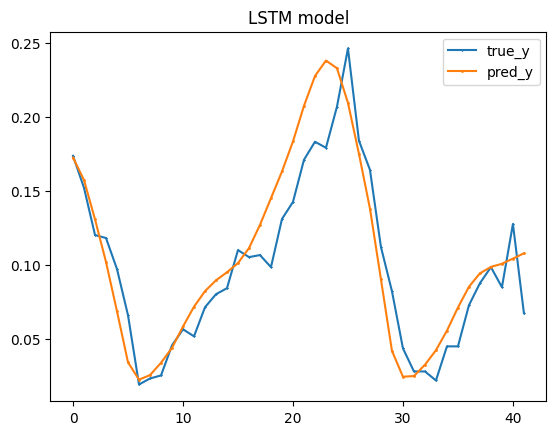

In [29]:
plt.title("LSTM model")
x=[i for i in range(len(y_valid))]
plt.plot(x,y_valid_passenger_count,marker="x",markersize=1,label="true_y")
plt.plot(x,preds_passenger_count,marker="o",markersize=1,label="pred_y")
plt.legend()
plt.show()

In [30]:
loss = 0
for i in range(len(y_valid)):
    loss += ((preds_passenger_count[i]-y_valid_passenger_count[i])**2)**0.5
    
print("总误差是{}".format(loss))

总误差是0.8000644134692214
